# Glove
http://www-nlp.stanford.edu/pubs/glove.pdf – Jeffrey Pennington, Richard Socher, Christopher D. Manning 2014.


### What is GloVe? :) 
*GloVe* is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.
More detailed explanation https://blog.acolyer.org/2016/04/22/glove-global-vectors-for-word-representation/

![alt text](http://building-babylon.net/wp-content/uploads/2016/02/glove-matrix-factorisation-3.jpg)

### Difference with word2vec
Word2Vec and GloVe learn geometrical encodings (vectors) of words from their co-occurrence information (how frequently they appear together in large text corpora). They differ in that word2vec is a "predictive" model, whereas GloVe is a "count-based" model.

Predictive models learn their vectors in order to improve their predictive ability of Loss(target word | context words; Vectors), i.e. the loss of predicting the target words from the context words given the vector representations. In word2vec, this is cast as a feed-forward neural network and optimized as such using SGD, etc.

Count-based models learn their vectors by essentially doing dimensionality reduction on the co-occurrence counts matrix. They first construct a large matrix of (words x context) co-occurrence information, i.e. for each "word" (the rows), you count how frequently we see this word in some "context" (the columns) in a large corpus.  The number of "contexts" is of course large, since it is essentially combinatorial in size. So then they factorize this matrix to yield a lower-dimensional (word x features) matrix, where each row now yields a vector representation for each word. In general, this is done by minimizing a "reconstruction loss" which tries to find the lower-dimensional representations which can explain most of the variance in the high-dimensional data. In the specific case of GloVe, the counts matrix is preprocessed by normalizing the counts and log-smoothing them. This turns out to be A Good Thing in terms of the quality of the learned representations.

However, as pointed out, when we control for all the training hyper-parameters, the embeddings generated using the two methods tend to perform very similarly in downstream NLP tasks. The additional benefits of GloVe over word2vec is that it is easier to parallelize the implementation which means it's easier to train over more data, which, with these models, is always A Good Thing.

### When to use?
Works better with neural nets, such as RNN/LSTM and CNN. On machine learning algorithms a result will be worse than on bag of words or on vectorizers.

In [33]:
import tf_glove

# Instantiating the model

To create a new GloVe model, simply call `tf_glove.GloVeModel()`:

In [2]:
model = tf_glove.GloVeModel(embedding_size=50, context_size=10, min_occurrences=25,
                            learning_rate=0.05, batch_size=512)

`GloVeModel()` has several parameters:
- **`embedding_size`**: the target dimensionality of the trained word representations. Typically between 50 and 300.
- **`context_size`**: how many tokens on either side of a given word to include in each context window. Can be either a tuple of two ints, indicating how many token on the left and right to include, or a single int, which will be interpreted to mean symmetric context.
- **`max_vocab_size`** *(Optional)*: the maximum size of the model's vocabulary. The model's vocabulary will be the most frequently occurring words in the corpus up to this amount. The default is 100,000.
- **`min_occurrences`** *(Optional)*: the minimum number of times a word must have appeared in the corpus to be included in the model's vocabulary. Default is 1.
- **`scaling_factor`** *(Optional)*: the alpha term in Eqn. 9 of Pennington et al.'s paper. Default is 3/4, which is the paper's recommendation
- **`cooccurrence_cap`** *(Optional)*: the x_max term in Eqn. 9 of Pennington et al.'s paper. Default is 100, which is the paper's recommendation
- **`batch_size`** *(Optional)*: the number of cooccurrences per minibatch of in training. Default is 512, which seems to work well on my machine. If training is very slow, consider playing with this.
- **`learning_rate`** *(Optional)*: the Adagrad learning rate used in training. Default is 0.05, which is the paper's recommendation

# Reading the corpus

tf_glove needs to be fit to a corpus in order to learn word representations. To do this, we'll use `GloVeModel.fit_to_corpus(corpus)`. This method expects an iterable of iterables of strings, where each string is a token, like this:

`[["this", "is", "a", "comment", "."], ["this", "is", "another", "comment", "."]]`

That was a list of lists, but any iterable of iterables of strings should work.

### Note on getting the dataset (if you want to follow along with these examples exactly)

For these examples, I'm going to use the dataset of Reddit comments described here: https://www.reddit.com/r/datasets/comments/3bxlg7/i_have_every_publicly_available_reddit_comment

tf_glove is designed to work with any corpus, so there's no need to download this dataset. However, if you'd like to, that post has a link to a torrent for all of the comments as well as a link for just the comments from January 2015. Even just the January 2015 file is quite large (~5 GB).

I downloaded it and used

`$ head -n 1000000 RC_2015-01 > /path/to/RC_2015-01-1m_sample`

to get the 1 million comment sample file referenced below. You could also use 100k if you want to save some time. 1 million comments takes ~15 minutes to fit on my machine.

## The structure of the input data:

In [45]:
with open('RC_2015-01-1m_sample', 'r') as file:
    print file.readline()
    print file.readline()

{"score_hidden":false,"name":"t1_cnas8zv","link_id":"t3_2qyr1a","body":"Most of us have some family members like this. *Most* of my family is like this. ","downs":0,"created_utc":"1420070400","score":14,"author":"YoungModern","distinguished":null,"id":"cnas8zv","archived":false,"parent_id":"t3_2qyr1a","subreddit":"exmormon","author_flair_css_class":null,"author_flair_text":null,"gilded":0,"retrieved_on":1425124282,"ups":14,"controversiality":0,"subreddit_id":"t5_2r0gj","edited":false}

{"distinguished":null,"id":"cnas8zw","archived":false,"author":"RedCoatsForever","score":3,"created_utc":"1420070400","downs":0,"body":"But Mill's career was way better. Bentham is like, the Joseph Smith to Mill's Brigham Young.","link_id":"t3_2qv6c6","name":"t1_cnas8zw","score_hidden":false,"controversiality":0,"subreddit_id":"t5_2s4gt","edited":false,"retrieved_on":1425124282,"ups":3,"author_flair_css_class":"on","gilded":0,"author_flair_text":"Ontario","subreddit":"CanadaPolitics","parent_id":"t1_cnas

## The code:

In [3]:
import re
import nltk

def extract_reddit_comments(path):
    # A regex for extracting the comment body from one line of JSON (faster than parsing)
    body_snatcher = re.compile(r"\{.*?(?<!\\)\"body(?<!\\)\":(?<!\\)\"(.*?)(?<!\\)\".*}")
    with open(path) as file_:
        for line in file_:
            match = body_snatcher.match(line)
            if match:
                body = match.group(1)
                # Ignore deleted comments
                if not body == '[deleted]':
                    # Return the comment as a string (not yet tokenized)
                    yield body
                        
def tokenize_comment(comment_str):
    # Use the excellent NLTK to tokenize the comment body
    #
    # Note that we're lower-casing the comments here. tf_glove is case-sensitive,
    # so if you want 'You' and 'you' to be considered the same word, be sure to lower-case everything.
    return nltk.wordpunct_tokenize(comment_str.lower())

def reddit_comment_corpus(path):
    # A generator that returns lists of tokens representing individual words in the comment
    return (tokenize_comment(comment) for comment in extract_reddit_comments(path))

# Replace the path with the path to your corpus file
corpus = reddit_comment_corpus("RC_2015-01-1m_sample")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 0 ns


Now, to fit the model to the corpus:

In [4]:
model.fit_to_corpus(corpus)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 0 ns
INFO:tensorflow:Summary name GloVe loss is illegal; using GloVe_loss instead.


# Training the model

GloVeModel.fit_to_corpus() builds the vocabulary and cooccurrence matrix that will be used in training, but it doesn't actually train the word representations. It's time to kick off TensorFlow and train the model for real:

In [5]:
model.train(num_epochs=50, log_dir="log/example", summary_batch_interval=1000)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 0 ns


`GloVeModel.train()` has a few parameters:
- **`num_epochs`**: How many passes through the cooccurrence matrix the training should make. The paper recommends at least 50 for `embedding_size` < 300, and 100 otherwise.
- **`log_dir`** *(Optional)*: The path of the directory in which to log summaries for TensorBoard and t-SNE visualizations. Default is `None`, i.e. don't log anything.
- **`summary_batch_interval`** *(Optional)*: How many minibatches between logging events for TensorBoard. Default is 1000.
- **`tsne_epoch_interval`** *(Optional)*: How many epochs (full passes through cooccurrence matrix) between outputting a t-SNE visualization of the model's embeddings for the most frequent 1000 words in the vocabulary. Default is None, i.e. don't output t-SNE visualizations during training.

# Checking out the results

Now that we've trained the model, let's look at the results.

Use `GloVeModel.embedding_for()` to get the trained embedding for a single word:

In [6]:
model.embedding_for("reddit")

array([-0.07224435,  0.79415286, -1.20036888, -0.20151283, -1.34046507,
        1.25561678,  0.75314271,  0.30898952, -0.18518566, -1.03356481,
       -1.05008781,  1.28799474, -0.2889888 ,  0.44469705, -0.32088   ,
        0.05573291,  1.03343785, -0.02865119,  0.12948714,  0.44088161,
       -0.88794255, -0.22869755,  0.41353944, -0.25184375,  0.10551563,
        0.5619753 , -0.14546597, -0.79858202,  0.01324186,  0.11346092,
        0.24418008,  0.11771496, -0.23772262, -1.31244087,  1.11657894,
        0.32210743, -0.11373767,  0.35161069, -0.26303524,  0.34371066,
       -0.24919936,  0.17440204,  0.21733898,  0.86114407, -0.27784711,
        0.69835651,  0.55879045, -1.26982772, -1.03286004, -0.47003019], dtype=float32)

You can also get the model's embeddings for every word in the vocabulary like this:

In [7]:
model.embeddings

array([[ 0.30572343,  0.46643785, -0.5898571 , ..., -0.15199639,
        -1.20194745, -0.17545867],
       [ 0.91367996,  0.03910809, -0.06476279, ...,  0.98569775,
        -0.66771734, -0.77738076],
       [ 0.65039325,  0.17131338, -0.23930797, ...,  0.25242254,
        -0.89917207, -0.4579125 ],
       ..., 
       [ 0.03729394,  0.30254811, -0.35787955, ..., -0.52142578,
        -0.30559993,  0.52964979],
       [-0.62927705,  0.79442608,  1.01850331, ...,  0.63637096,
         0.59137619, -0.51800507],
       [ 0.83351505, -0.42992446,  1.25380206, ...,  0.27873552,
         1.23854351, -0.09686151]], dtype=float32)

`GloVeModel.embeddings` will give you a NumPy matrix where each row is the model's embedding for a single word.

To make use of this, you'll want to know what row corresponds to a particular word. You can do that with `GloVeModel.id_for_word`:

In [8]:
model.embeddings[model.id_for_word('reddit')]

array([-0.07224435,  0.79415286, -1.20036888, -0.20151283, -1.34046507,
        1.25561678,  0.75314271,  0.30898952, -0.18518566, -1.03356481,
       -1.05008781,  1.28799474, -0.2889888 ,  0.44469705, -0.32088   ,
        0.05573291,  1.03343785, -0.02865119,  0.12948714,  0.44088161,
       -0.88794255, -0.22869755,  0.41353944, -0.25184375,  0.10551563,
        0.5619753 , -0.14546597, -0.79858202,  0.01324186,  0.11346092,
        0.24418008,  0.11771496, -0.23772262, -1.31244087,  1.11657894,
        0.32210743, -0.11373767,  0.35161069, -0.26303524,  0.34371066,
       -0.24919936,  0.17440204,  0.21733898,  0.86114407, -0.27784711,
        0.69835651,  0.55879045, -1.26982772, -1.03286004, -0.47003019], dtype=float32)

And if you want to see a 2D visualization of the learned vector space, you can use `GloVeModel.generate_tsne()`:

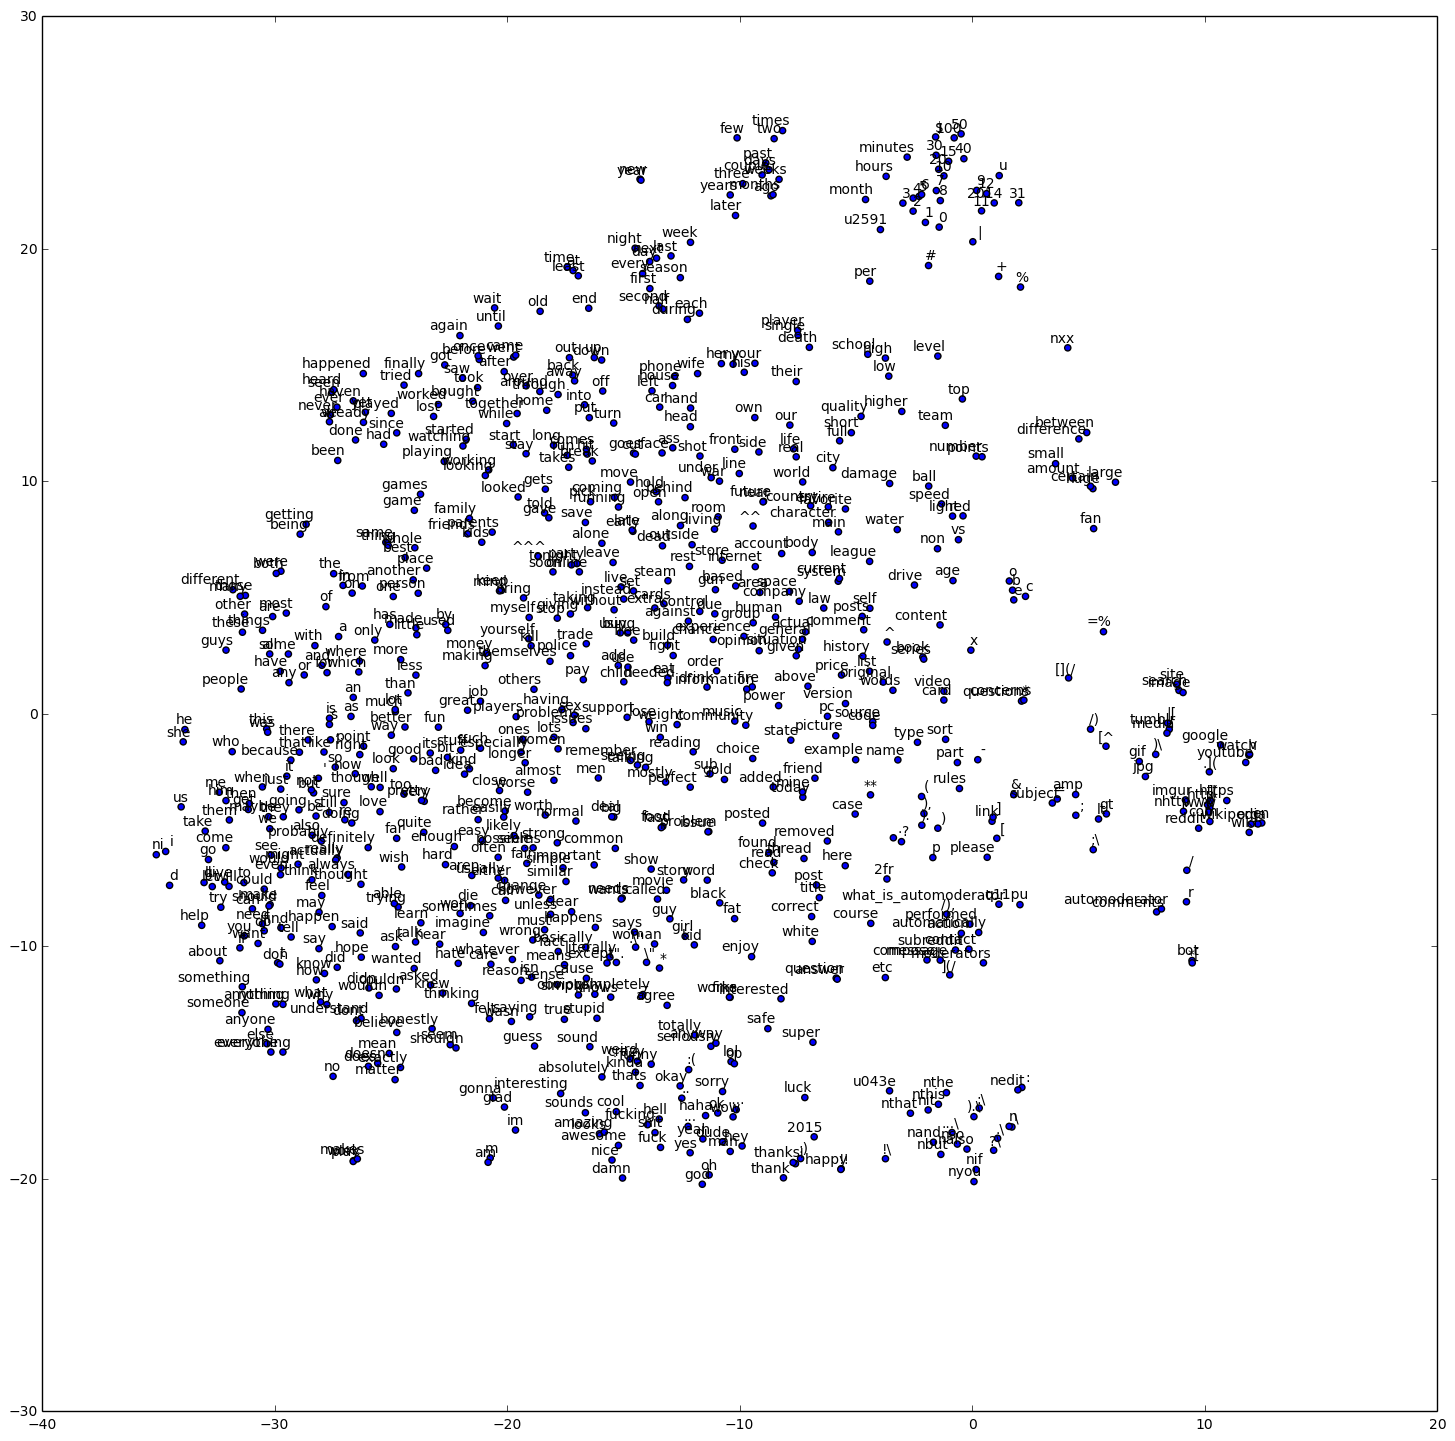

In [39]:
%matplotlib inline
model.generate_tsne(size=(18,18), word_count=800)

You might want to open that image in a new tab.

With no parameters, `GloVeModel.generate_tsne()` can be used interactively like in this notebook, but it also has parameters that will let you save the visualization to a file and adjust the size of the image and how many words appear:

- **`path`** *(Optional)*: The path at which to save the generated PNG image. Default is None, which only really makes sense for interactive environments.
- **`size`** *(Optional)*: A tuple of (width, height) in *inches*. (Yeah, I know right? This is inherited from matplotlib.) Default is 100 x 100.  
- **`word_count`** *(Optional)*: How many words to plot in the visualization. Default is 1000, which works fairly well for a (100 x 100) visualization.



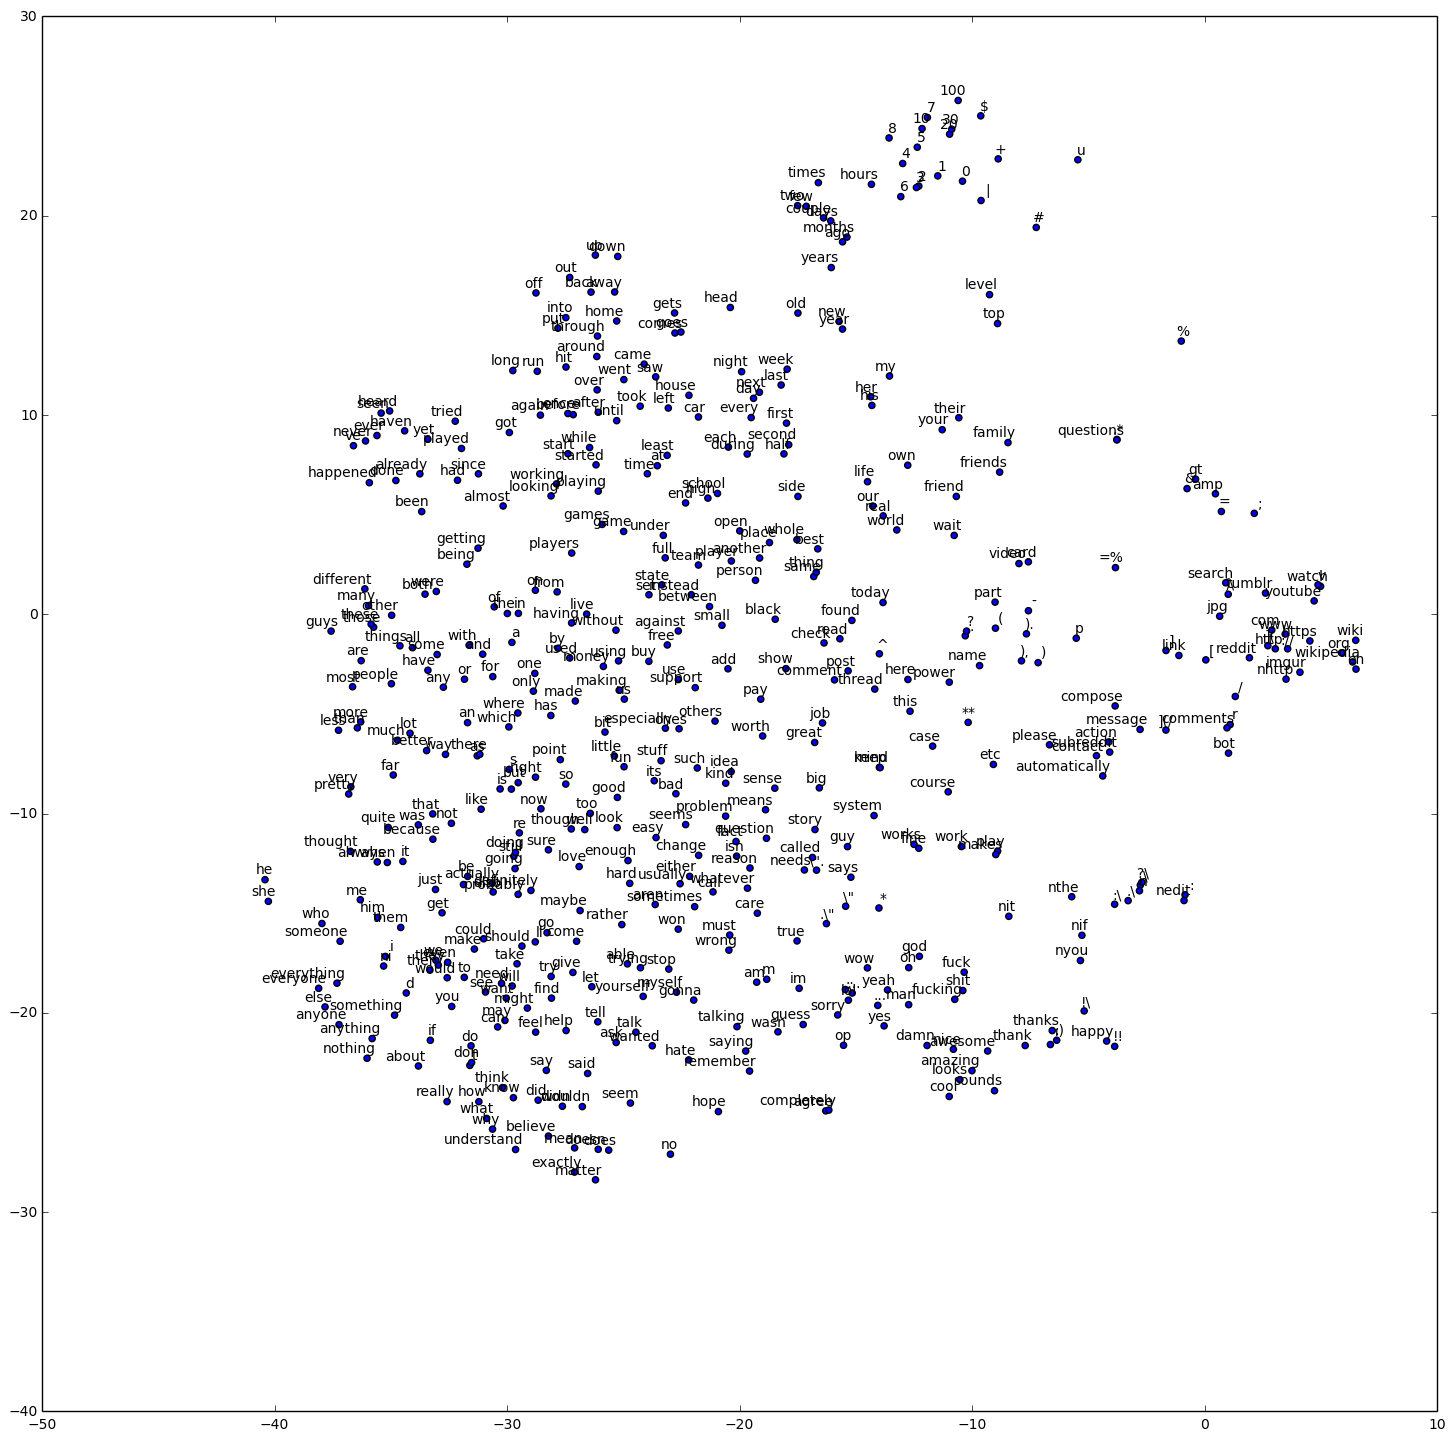

In [35]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)



tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(model.embeddings[:plot_only, :])
labels = [model.words[i] for i in xrange(plot_only)]
plot_with_labels(low_dim_embs, labels)

In [19]:
len(model.words)

11476